## Options Correlation 

This file is created for the project 3 of Option Correlation. The purpose of this project is to compare the daily options prices of each company/ticker against the equity price change. 


* **SP Tian** 
* **Aug 1, 2019** 

* **Presentation: Sep 14, 2019** 


In [1]:
# Import packages and set up 

import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 

%matplotlib inline 
from scipy.interpolate import interp1d
?scipy.interpolate

Object `scipy.interpolate` not found.


In [2]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < -0.8 else 'black'
    return 'color: %s' % color

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def color_positive_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'green' if val > 0.8 else 'black'
    return 'color: %s' % color


### Import Data

In [3]:
# No need to run 
SP500 = pd.read_excel("SP500.xlsx", sheetname = "Ticker", index_col=None, header=None)
SP500 = SP500[0]
SP500.to_pickle("SP500 tickers.pkl")
SP500.sample(20)

/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


180     RHT
63       GE
372      CE
328     EFX
294    FAST
450     MOS
457    NLSN
223     RCL
104    SPGI
89      CSX
411     AES
330     PFG
483       M
331    NTAP
311    CPRT
306     KEY
269     LLL
118     ITW
24       HD
481      LB
Name: 0, dtype: object

In [3]:
SP500 = pd.read_pickle("/Users/apple/Desktop/Desktop/SP500 tickers.pkl")
print(SP500.shape)
SP500.sample(20)

(511,)


509     NaN
193     TEL
118     ITW
452     IPG
403     AAP
139    EQIX
483       M
188     PEG
162     JCI
226     GPN
186    PAYX
117     ICE
63       GE
390    SYMC
366     VNO
481      LB
377     TAP
153     DOW
368     DXC
146     TRV
Name: 0, dtype: object

> Explaination of SP 500 Tickers 

502 tickers of the largest-sized market capital companies, in and out. 

In [4]:
optionschain = pd.read_excel("SP500.xlsx", sheetname = "Options", index_col=None, header=None)

/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [5]:
print(optionschain.shape)
optionschain[0].sample(10)

(103066, 1)


44190     @DE    190802P00149000
86057     @MGM   190823C00031000
88248     @XRAY  190920P00050000
68928     @CMI   190913P00146000
19588     @PM    191220P00080000
93251     @UAA   190809C00022000
4437      @GOOG  190809C01252500
28727     @BKNG  190802C02032500
100669    @IPGP  191220C00130000
75001     @CTVA  200117C00033000
Name: 0, dtype: object

> Explain the optionschain 

1. @ means options 
2. Ticker = equity/stock 
3. P/C = Put and Call 
4. date format: 2019 - 09 - 13 
5. 00xxx: strike price 
6. x00: decimal digit of strike price 

#### Import October options data - for validation 

In [6]:
put10 = pd.read_excel("SP500.xlsx", sheetname = "Sheet1", index_col = "date")
print(put10.shape)
#put10.style

(23, 155)


In [7]:
call10 = pd.read_excel("SP500.xlsx", sheetname = "Sheet2", index_col = "date")
print(call10.shape)
#call10.style

(23, 155)


In [52]:
put_op = pd.read_excel("SP500.xlsx", sheetname = "OptionPut", index_col='date')
print(put_op.shape)
put_op.style

(29, 502)


In [53]:
call_op = pd.read_excel("SP500.xlsx", sheetname = "OptionCall", index_col='date')
print(call_op.shape)
call_op.style

(29, 502)


In [5]:
equity = pd.read_excel("SP500.xlsx", sheetname = "Equity", index_col='Date')
print(equity.shape)
equity.style

(30, 502)


### Interpolate 


Extrapolation is an estimation of a value based on extending a known sequence of values or facts beyond the area that is certainly known. ... Interpolation is an estimation of a value within two known values in a sequence of values. Polynomial interpolation is a method of estimating values between known data points.


There are many np.NaN in the put/call options, so in order to better adjust each data point to calculater the correlation, we used interpolations in two ways: 
1. Linear 
2. Timely 

#### Fill NAs ---> Price ---> % Return ---> Corr 

In [56]:
def logReturn(df): 
    """
    Calculate the return from daily trading prices 
    Return = log(t+1)/log(t) of close prices 
    Input: df
    (put_op = data frame with put options, 500 cols
    call_op = data frame with call options, 500 cols 
    equity = data frame with stock equity, 500 cols)
    Output: df indicating daily returns 
    NOTE: first row empty as np.nan 
    """
    
    result_dict = {}
    for a in df.columns: 
        result_dict[a] = np.log(df[a].shift(1)) - np.log(df[a])
    return pd.DataFrame(result_dict)

def pairCorr(df1, df2): 
    """
    Get pair correlation instead cross correlation table 
    Correlation calculated from a series of options data over equity, 
        within a time date index 
    Input: df1, df2 (return or price)
    Output: correlation table df 
    """
    
    result = pd.DataFrame(index = df1.columns, columns = df2.columns)
    for to in df1.columns:
        for tc in df2.columns:
            result.set_value(to, tc, df1[to].corr(df2[tc]))
    return result

def dictCorr(df1, df2): 
    result_dict = {}
    for to in df1.columns: 
        for tc in df2.columns: 
            result_dict[(to, tc)] = df1[to].corr(df2[tc])
    return result_dict 

def testCorr(corr): 
    result = corr[((corr > 0.9) | (corr < -0.9)).any(axis = 1)]
    if np.isnan(result[result > 10]): 
        return result 


In [7]:
def naCount(df): 
    """
    This functions calculates the na (aka. np.nan)
    in the dataframe by columns. 
    Input: df 
    Output: a df showing the na by seperate columns
    (can be print or stored) 
    """
    
    na_df = df.isnull().sum()
    na_df = na_df[na_df > 0]
    return na_df 

In [54]:
naCount(put_op)

@GOOG  190920P01190000     6
@FB    190809P00185000    14
@JNJ   190920P00130000     1
@JPM   190920P00110000     1
@XOM   190920P00070000     1
@WMT   190920P00110000     1
@PG    190920P00120000     3
@BAC   190920P00028000     1
@MA    190920P00280000     1
@DIS   190920P00135000     1
@PFE   191220P00035000     2
@VZ    190920P00055000     1
@CSCO  190920P00050000     1
@UNH   190920P00240000     1
@T     190920P00035000     1
@CVX   190920P00125000     2
@KO    190920P00055000     1
@HD    190920P00215000     1
@MRK   190920P00085000     1
@WFC   190920P00045000     1
@INTC  190920P00047000     1
@BA    190920P00335000     1
@CMCSA 190920P00042500     1
@PEP   190920P00130000     1
@ORCL  190920P00052500     2
@NFLX  190920P00305000     1
@MCD   190920P00220000     1
@C     190920P00065000     1
@ABT   190920P00085000     1
@ADBE  190920P00290000     1
                          ..
@IPGP  190920P00125000    21
@SEE   190920P00040000    16
@NWSA  190920P00014000    23
@FLIR  190920P

In [55]:
naCount(call_op)

@GOOG  190920C01190000     3
@FB    190809C00185000    14
@V     190920C00180000     1
@JNJ   190920C00130000     1
@JPM   190920C00110000     1
@XOM   190920C00070000     3
@WMT   190920C00110000     1
@PG    190920C00120000     1
@BAC   190920C00028000     1
@MA    190920C00280000     1
@DIS   190920C00135000     1
@PFE   191220C00035000     5
@VZ    190920C00055000     1
@CSCO  190920C00050000     1
@UNH   190920C00240000     1
@T     190920C00035000     1
@CVX   190920C00125000     1
@KO    190920C00055000     1
@HD    190920C00215000     1
@MRK   190920C00085000     1
@WFC   190920C00045000     1
@INTC  190920C00047000     1
@BA    190913C00360000     8
@CMCSA 190920C00042500     1
@PEP   190920C00130000     1
@ORCL  190920C00052500     2
@NFLX  190920C00305000     1
@MCD   190920C00220000     1
@C     190920C00065000     1
@ABT   190920C00085000     1
                          ..
@IPGP  190920C00125000    15
@SEE   190920C00040000    29
@NWSA  190920C00014000    23
@FLIR  190920C

In [10]:
naCount(equity)

APC    17
TMK    30
AOS    30
dtype: int64

In [11]:
put_op = put_op.interpolate(method = "time", limit = 20)

In [12]:
call_op = call_op.interpolate(method = "time", limit = 20)

In [18]:
# No need to run 
#put_op.to_excel("put_op.xlsx")
#call_op.to_excel("call_op.xlsx")
put_op = pd.read_excel("put_op.xlsx")
call_op = pd.read_excel("call_op.xlsx")

In [21]:
equity_re = logReturn(equity)
put_re = logReturn(put_op)
call_re = logReturn(call_op)

put_re = put_re.shift(-1).iloc[:-1]
call_re = call_re.shift(-1).iloc[:-1]

equity_re = equity_re.iloc[1:]
equity_re.shape

(29, 502)

In [22]:
corr_put = pairCorr(put_re, equity_re)
corr_call = pairCorr(call_re, equity_re)
corr_put

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


MSFT         AMZN        AAPL      GOOGL  \
@MSFT  190920P00140000    0.183332     0.244447   0.0565887   0.146955   
@AMZN  190920P01800000   0.0847195     0.159542   0.0167652   0.109588   
@AAPL  190920P00210000    0.121771     0.194757    0.134094   0.170865   
@GOOGL 190920P01200000   0.0885762     0.229802 -0.00229847  0.0866241   
@GOOG  190920P01190000  -0.0515507    -0.070362   -0.106989   0.352417   
@BRKB  190920P00200000    0.223776     0.291459    0.213618   0.207138   
@FB    190809P00185000   -0.154671    0.0613055    0.150431  -0.218869   
@V     190920P00180000    0.104502     0.172512    0.105953   0.210134   
@JNJ   190920P00130000    0.227766     0.315781    0.130419  0.0686234   
@JPM   190920P00110000 -0.00417739    -0.118596   -0.222434  -0.108485   
@XOM   190920P00070000   0.0755454     0.251161     0.25144   0.113196   
@WMT   190920P00110000  -0.0694998   -0.0878922  -0.0249307  0.0584024   
@PG    190920P00120000    0.229311     0.160297  -0.0273682 -0.0168451   
@BAC   190920P00028000   -0.188921     -0.10961  -0.0935652  0.0318324   
@MA    190920P00280000    0.176657     0.227904   0.0512601  0.0960196   
@DIS   190920P00135000     0.24817    0.0767297    -0.17821 -0.0188637   
@PFE   191220P00035000    0.259522     0.258407    0.207157    0.13732   
@VZ    190920P00055000   0.0216384     0.139308   -0.118254  0.0365676   
@CSCO  190920P00050000    0.235209      0.27922     0.18804   0.136448   
@UNH   190920P00240000     0.11846     0.141727  -0.0349128   0.204525   
@T     190920P00035000    0.156203     0.219177    0.348926   0.110883   
@CVX   190920P00125000   0.0222238   0.00323924   0.0207198  0.0978306   
@KO    190920P00055000  -0.0498117   -0.0261865   0.0394553   0.116352   
@HD    190920P00215000     0.12832    0.0995797 -0.00182713  -0.066514   
@MRK   190920P00085000    0.148228     0.127181   0.0164499 -0.0522053   
@WFC   190920P00045000   -0.189695    -0.329663   -0.134422 -0.0879179   
@INTC  190920P00047000   -0.327075    -0.266918   -0.399532  -0.252974   
@BA    190920P00335000    0.278614      0.15397    0.117712   0.325808   
@CMCSA 190920P00042500         NaN          NaN         NaN        NaN   
@PEP   190920P00130000  -0.0318297   -0.0311565  -0.0106949 -0.0250207   
...                            ...          ...         ...        ...   
@IPGP  190920P00125000    0.339399      0.32101    0.307092   0.176743   
@SEE   190920P00040000         NaN          NaN         NaN        NaN   
@NWSA  190920P00014000    0.545341     0.477895    0.480877   0.410626   
@FLIR  190920P00050000    -0.21911     0.052757   -0.141889 -0.0543679   
@PVH   190920P00075000  -0.0540453  0.000767294  -0.0133896 -0.0369179   
@LB    190920P00022500    0.125681     0.330972    0.361754   0.172707   
@RHI   190920P00055000   -0.277238    -0.417053   -0.308854 -0.0960637   
@M     190920P00019000   -0.049262   -0.0713388   -0.114722 -0.0220179   
@PBCT  190920P00014000 -0.00400754   -0.0628804  -0.0420386 -0.0450033   
@AIZ   190920P00115000  -0.0404484    -0.130414  0.00566375 -0.0377341   
@FLS   190920P00045000   -0.244398    -0.192285   -0.235013  -0.118129   
@TRIP  190920P00040000   -0.256755    -0.306743   -0.395287  -0.152323   
@NWL   190920P00016000         NaN          NaN         NaN        NaN   
@PNR   190920P00035000     0.11684    0.0680365    0.209946   0.105003   
@PRGO  190920P00050000  -0.0542189   -0.0704552   -0.116253 -0.0897422   
@NKTR  190920P00018000     0.23396     0.150987    0.167268   0.229786   
@HBI   190920P00014000   -0.254363    -0.303429   -0.256024  -0.220865   
@XEC   190920P00045000    0.249851     0.339367    0.177178   0.170513   
@HRB   190920P00025000   -0.297868    -0.234303   -0.164462  -0.165846   
@HP    190920P00040000    0.222917     0.170842    0.178005   0.128519   
@HOG   190920P00032500         NaN          NaN         NaN        NaN   
@PWR   190920P00034000    0.481785     0.484277    0.420531   0.351248   
@JEF   190920P00020000    0.183572

### Graph

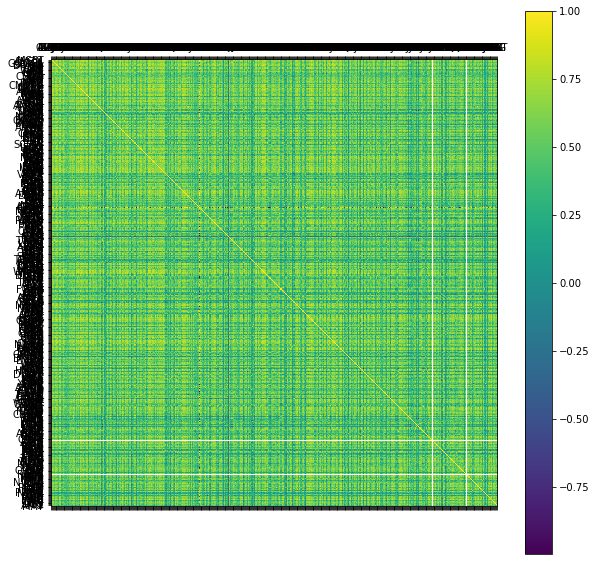

In [48]:
def plot_corr(df, size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    img = ax.matshow(corr)
    fig.colorbar(img)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

plot_corr(equity_re)

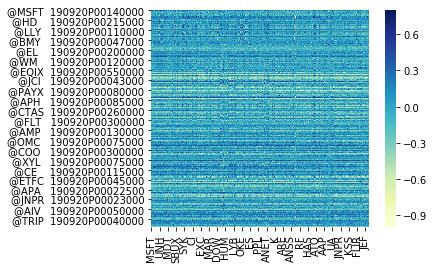

In [44]:
corr_put = corr_put[corr_put.columns].astype(float)
sns.heatmap(corr_put, vmax = 0.8, cmap="YlGnBu", square = True)

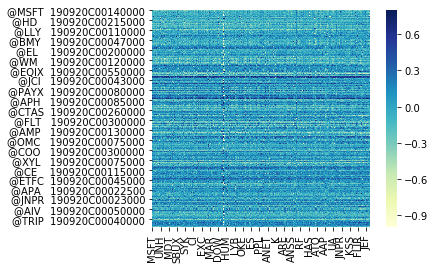

In [45]:
corr_call = corr_call[corr_call.columns].astype(float)
sns.heatmap(corr_call, vmax = 0.8, cmap = "YlGnBu", square = True)

## Selection

AMZN & MSFT: when AMZN down, AMZN call options down; MSFT up, MSFT call options down; buy MSFT call options cuz trend of getting up. 

return_t = log (price_t) / log (price_(t-1))

In [35]:
dict_put = dictCorr(put_re, equity_re)

In [96]:
dictCorr(put_re, equity_re).to_pickle("dictPut.pkl")

{('@MSFT  190920P00140000', 'MSFT'): 0.1833323915074863,
 ('@MSFT  190920P00140000', 'AMZN'): 0.24444663487641052,
 ('@MSFT  190920P00140000', 'AAPL'): 0.05658871309111348,
 ('@MSFT  190920P00140000', 'GOOGL'): 0.14695548713403378,
 ('@MSFT  190920P00140000', 'GOOG'): 0.15142689710149437,
 ('@MSFT  190920P00140000', 'BRK.B'): 0.135828003112655,
 ('@MSFT  190920P00140000', 'FB'): 0.2562473049976327,
 ('@MSFT  190920P00140000', 'V'): 0.11217953462252574,
 ('@MSFT  190920P00140000', 'JNJ'): -0.06132664049236927,
 ('@MSFT  190920P00140000', 'JPM'): 0.02946536348085849,
 ('@MSFT  190920P00140000', 'XOM'): 0.003036867345660978,
 ('@MSFT  190920P00140000', 'WMT'): 0.30009803754313713,
 ('@MSFT  190920P00140000', 'PG'): 0.10014048136670177,
 ('@MSFT  190920P00140000', 'BAC'): -0.047978126402190034,
 ('@MSFT  190920P00140000', 'MA'): 0.2026042942108169,
 ('@MSFT  190920P00140000', 'DIS'): 0.14214490263241886,
 ('@MSFT  190920P00140000', 'PFE'): 0.12350112677113255,
 ('@MSFT  190920P00140000', '

In [42]:
#dict_put = read_pickle("dictPut.pkl")
keys = list(dict_put.keys())
values = list(dict_put.values())
indices = np.where(abs(np.array(values)) > 0.9)[0]

results = {}
for index in indices:
    key = keys[index]
    value = values[index]
    results[key] = value
results

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


{('@BAC   190920P00028000', 'APC'): -0.9883675329162237,
 ('@DIS   190920P00135000', 'APC'): 0.9688295185403965,
 ('@CSCO  190920P00050000', 'APC'): 0.9489781853673726,
 ('@T     190920P00035000', 'APC'): 0.9998308048072244,
 ('@WFC   190920P00045000', 'APC'): -0.9440921802689418,
 ('@PEP   190920P00130000', 'ULTA'): -0.9392620439986141,
 ('@MCD   190920P00220000', 'APC'): 0.9536226100747679,
 ('@ABT   190920P00085000', 'APC'): 0.9552198805729245,
 ('@AMGN  190920P00200000', 'APC'): -0.9837284714794073,
 ('@DHR   190920P00135000', 'APC'): 0.9217144762818735,
 ('@MMM   190920P00160000', 'ABMD'): -0.9196065619837459,
 ('@GE    190920P00010000', 'APC'): -0.9538521575825406,
 ('@BMY   190920P00047000', 'APC'): 0.9924246649579785,
 ('@MS    190920P00040000', 'APC'): -0.9916233688834847,
 ('@SYK   190920P00220000', 'APC'): 0.9868568127388948,
 ('@SO    190920P00057500', 'APC'): 0.9950584017467418,
 ('@DD    190920P00065000', 'APC'): 0.9186865473957967,
 ('@CCI   190920P00145000', 'APC'): 0.9

In [43]:
dict_call = dictCorr(call_re, equity_re)
keys = list(dict_call.keys())
values = list(dict_call.values())
indices = np.where(abs(np.array(values)) > 0.9)[0]

res = {}
for index in indices:
    key = keys[index]
    value = values[index]
    res[key] = value
res

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


{('@BRKB  190920C00200000', 'APC'): -0.9600343106200315,
 ('@JPM   190920C00110000', 'APC'): -0.9532328107264634,
 ('@JPM   190920C00110000', 'ULTA'): -0.9070301468317875,
 ('@WMT   190920C00110000', 'APC'): -0.9718800816892824,
 ('@BAC   190920C00028000', 'APC'): -0.9838764729238327,
 ('@DIS   190920C00135000', 'APC'): -0.993994571377916,
 ('@T     190920C00035000', 'APC'): 0.9096731205849814,
 ('@CVX   190920C00125000', 'APC'): -0.9363501103193527,
 ('@CMCSA 190920C00042500', 'APC'): -0.9505504282634712,
 ('@CMCSA 190920C00042500', 'DXC'): -0.9104667132519346,
 ('@ABT   190920C00085000', 'APC'): -0.9941611995470195,
 ('@MDT   190920C00105000', 'APC'): -0.9524011807542784,
 ('@UNP   190920C00170000', 'APC'): -0.9873236942641428,
 ('@ACN   190920C00190000', 'APC'): -0.9823850091463698,
 ('@UTX   190920C00130000', 'APC'): -0.9325673098399889,
 ('@LIN   190920C00185000', 'APC'): -0.9818557470200572,
 ('@QCOM  190920C00075000', 'APC'): -0.9646727886587602,
 ('@BKNG  191018C01910000', 'APC

In [ ]:
import missingno
missingo.bar(df)

df.columns
pd.isnull(df).astype(int).aggregate(sum).to_dict() 

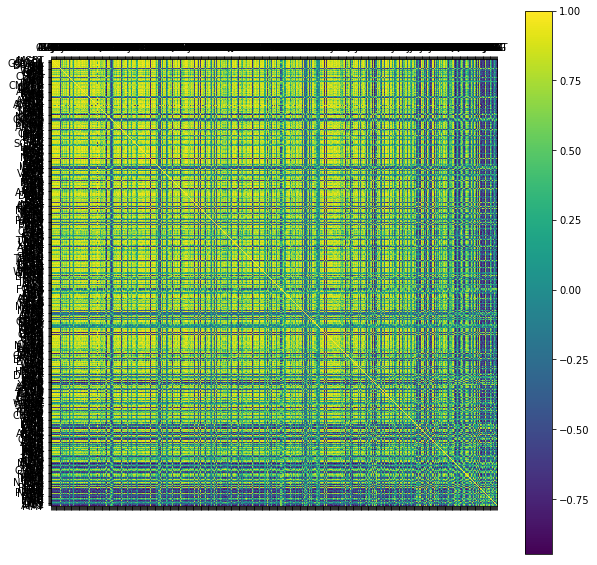

In [50]:
stock = pd.read_excel("SP500.xlsx", sheetname = "Shadar", index_col = "Date")
plot_corr(stock)

In [51]:
stock.corr().to_excel("stock_corr.xlsx")